<a href="https://colab.research.google.com/github/KwonDuHyeon/hanghae99/blob/main/2%EC%A3%BC%EC%B0%A8%EA%B8%B0%EB%B3%B8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
pip install datasets sacremoses

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


## [MY CODE]Last word prediction dataset 준비(과제)

In [56]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from torch.nn.utils.rnn import pad_sequence
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-2])
    texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-2]))


  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels

train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)



Using cache found in /home/harry/.cache/torch/hub/huggingface_pytorch-transformers_main


## Self Attention

In [57]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result



## TransformerLayer layer

In [58]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x


## Positional encoding

In [59]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


## [MY CODE] TextClassifier 출력 차원 수정

In [60]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, vocab_size) # [과제] 출력 차원 수정 1-> vocab_size

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x


model = TextClassifier(len(tokenizer), 32, 2, 32)




## [MY CODE]Loss Function 수정(CrossEntropyLoss())

In [61]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR # StepLR 추가

lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [62]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1) # 가장 높은 확률 클래스 선택
    # preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

## [MY CODE] Checkpoint 저장

In [63]:
import os
from pathlib import Path
def save_checkpoint(model, optimizer, epoch, train_acc, test_acc, filename):


    save_path = os.path.join('/mnt/d/colab/2week/basic/', filename)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_acc_list': train_acc_list,
        'test_acc_list': test_acc_list
    }
    torch.save(checkpoint, save_path)
    print(f"Checkpoint saved: {save_path}")

## [MY CODE] 학습 진행

In [64]:
n_epochs = 50
best_acc = 0.0
train_acc_list = []
test_acc_list = []



for epoch in range(n_epochs):
  total_loss = 0.
  model.train()

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

    save_checkpoint(model, optimizer, epoch, train_acc, test_acc,
                       f'checkpoint_epoch_{epoch}.pth')


    if test_acc > best_acc:
        best_acc = test_acc
        save_checkpoint(model, optimizer, epoch, train_acc, test_acc,
                        'best_model.pth')
        print(f"New best model saved with test accuracy: {test_acc:.3f}")

Epoch   0 | Train Loss: 1502.4189670085907
=========> Train acc: 0.558 | Test acc: 0.564
Checkpoint saved: /mnt/d/colab/2week/basic/checkpoint_epoch_0.pth
Checkpoint saved: /mnt/d/colab/2week/basic/best_model.pth
New best model saved with test accuracy: 0.564
Epoch   1 | Train Loss: 1179.0684309005737
=========> Train acc: 0.558 | Test acc: 0.564
Checkpoint saved: /mnt/d/colab/2week/basic/checkpoint_epoch_1.pth
Epoch   2 | Train Loss: 1141.4919648170471
=========> Train acc: 0.558 | Test acc: 0.564
Checkpoint saved: /mnt/d/colab/2week/basic/checkpoint_epoch_2.pth
Epoch   3 | Train Loss: 1125.4107120037079
=========> Train acc: 0.558 | Test acc: 0.564
Checkpoint saved: /mnt/d/colab/2week/basic/checkpoint_epoch_3.pth
Epoch   4 | Train Loss: 1095.5243744850159
=========> Train acc: 0.558 | Test acc: 0.564
Checkpoint saved: /mnt/d/colab/2week/basic/checkpoint_epoch_4.pth
Epoch   5 | Train Loss: 1074.597777247429
=========> Train acc: 0.558 | Test acc: 0.564
Checkpoint saved: /mnt/d/colab/2

[LOG] scheduler StepLR 사용하니 더 떨어진다


## [MY CODE] Plot 함수

In [65]:
def plot_accuracy(train_acc_list, test_acc_list):
    plt.figure(figsize=(10, 6))

    epochs = range(len(train_acc_list))
    plt.plot(epochs, train_acc_list, label='Train Accuracy', linestyle='-', marker='o')
    plt.plot(epochs, test_acc_list, label='Test Accuracy', linestyle='--', marker='x')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

## [MY CODE] Plot 출력

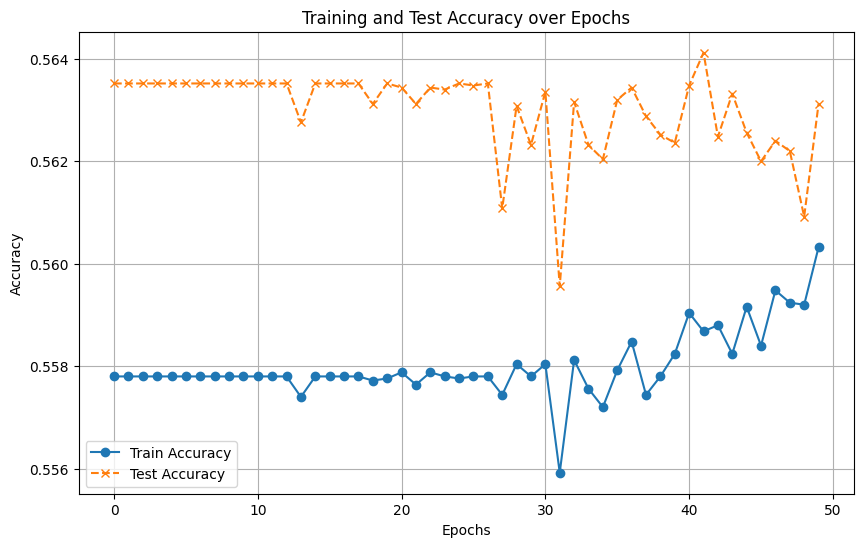

In [66]:
plot_accuracy(train_acc_list, test_acc_list)

[FEEDBACK] test accuracy 결과가 학습이 제대로 안된것 같습니다 이게 정상적으로 진행이 된게 맞을까요??